Importing Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# For machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# For evaluation
import time
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# For clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loading the Dataset

In [2]:
# Mount Google Drive, in case using Colab. If not, ignore this step.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the datasets and merge them into one large DataFrame.
filenames = [
    '/content/drive/MyDrive/Colab Notebooks/SEO London 2025/processed_datasets/reassigned_economy_business_financial_services.csv',
    '/content/drive/MyDrive/Colab Notebooks/SEO London 2025/processed_datasets/reassigned_energy_&_resources.csv',
    '/content/drive/MyDrive/Colab Notebooks/SEO London 2025/processed_datasets/reassigned_healthcare.csv',
    '/content/drive/MyDrive/Colab Notebooks/SEO London 2025/processed_datasets/reassigned_technology.csv'
]
dataframes = [pd.read_csv(filename) for filename in filenames]
df = pd.concat(dataframes, ignore_index=True)

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Basic statistics
print("\nStatistical summary of the dataset:")
print(df.describe(include='all'))

# Check class distribution
print("\nDistribution of topics:")
print(df['topic'].value_counts())
print("\nDistribution of subtopics:")
print(df['subtopic'].value_counts())

Dataset shape: (45744, 4)

First few rows:
                                               title  \
0                   Credit Suisse to Integrate Units   
1  UPDATE 2-National City 3rd-quarter profit rise...   
2             A Simpler Conversion (The Motley Fool)   
3                    Freddie Mac to Restructure Unit   
4           M T Bank Profit Rises on Fewer Bad Loans   

                                         description  \
0   ZURICH (Reuters) - Credit Suisse will integra...   
1  National City Corp. (NCC.N: Quote, Profile, Re...   
2  The Motley Fool - In 2005, a little-known chan...   
3  Government-sponsored lender Freddie Mac said M...   
4   NEW YORK (Reuters) - M T Bank Corp. &lt;A HRE...   

                                 topic          subtopic  
0  Economy/Business/Financial Services  Banking Services  
1  Economy/Business/Financial Services  Banking Services  
2  Economy/Business/Financial Services  Banking Services  
3  Economy/Business/Financial Services  Banking

Data Preprocessing and Cleaning

In [4]:
# Create a function for text cleaning
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""  # Return empty string for non-text values

# Apply cleaning to title and description
df['clean_title'] = df['title'].apply(clean_text)
df['clean_description'] = df['description'].apply(clean_text)

# Combine title and description for feature creation
df['text'] = df['clean_title'] + " " + df['clean_description']

# Lemmatization and stop word removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization
df['processed_text'] = df['text'].apply(lemmatize_text)

# Show a sample of processed text
print("Sample of processed text:")
print(df[['title', 'processed_text']].head())

# Check for any remaining empty texts after processing
empty_texts = df[df['processed_text'] == ''].shape[0]
print(f"\nNumber of empty texts after processing: {empty_texts}")

# Remove any rows with empty processed text (if any)
if empty_texts > 0:
    df = df[df['processed_text'] != ''].reset_index(drop=True)
    print(f"Removed {empty_texts} rows with empty text.")

Sample of processed text:
                                               title  \
0                   Credit Suisse to Integrate Units   
1  UPDATE 2-National City 3rd-quarter profit rise...   
2             A Simpler Conversion (The Motley Fool)   
3                    Freddie Mac to Restructure Unit   
4           M T Bank Profit Rises on Fewer Bad Loans   

                                      processed_text  
0  credit suisse integrate unit zurich reuters cr...  
1  update national city rdquarter profit rise pct...  
2  simpler conversion motley fool motley fool lit...  
3  freddie mac restructure unit governmentsponsor...  
4  bank profit rise fewer bad loan new york reute...  

Number of empty texts after processing: 0


Feature Extraction

TF-IDF feature matrix shape: (45744, 5000)
TF-IDF matrix sparsity: 0.99


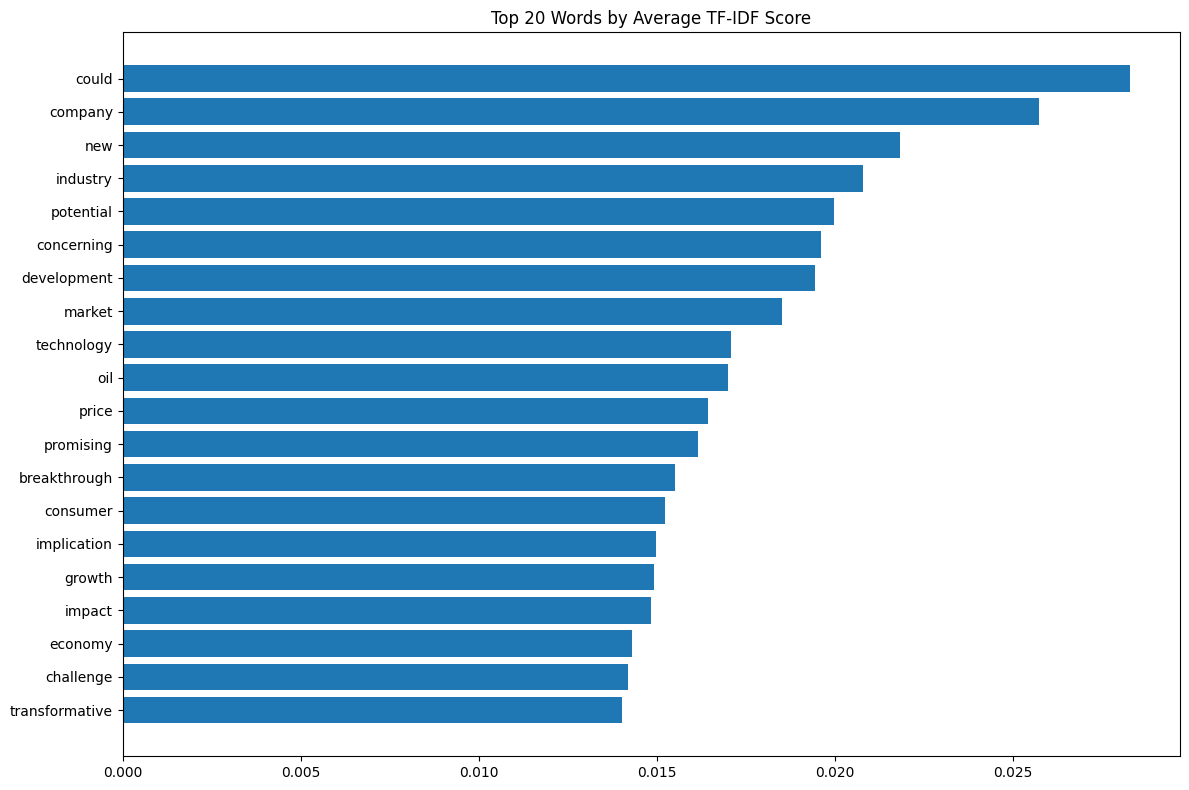

In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Define the target variable
y = df['subtopic']

# Print dimensions of the feature matrix
print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")

# Convert sparse matrix to array for visualization
tfidf_array = X_tfidf.toarray()

# Visualize feature sparsity
sparsity = 1.0 - (np.count_nonzero(tfidf_array) / tfidf_array.size)
print(f"TF-IDF matrix sparsity: {sparsity:.2f}")

# Visualize most common words
feature_names = tfidf_vectorizer.get_feature_names_out()
top_indices = np.argsort(np.mean(tfidf_array, axis=0))[-20:]  # Top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(20), np.mean(tfidf_array, axis=0)[top_indices])
plt.yticks(range(20), [feature_names[i] for i in top_indices])
plt.title('Top 20 Words by Average TF-IDF Score')
plt.tight_layout()
plt.show()

Train-Test Split

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shapes of the resulting splits
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Check class distribution in train and test sets
print("\nTraining set subtopic distribution:")
print(pd.Series(y_train).value_counts().head())
print("\nTest set subtopic distribution:")
print(pd.Series(y_test).value_counts().head())

Training features shape: (36595, 5000)
Training labels shape: (36595,)
Testing features shape: (9149, 5000)
Testing labels shape: (9149,)

Training set subtopic distribution:
subtopic
Cloud and Software       4502
Corporate Performance    3573
Hardware and Devices     3451
Markets and Trading      3078
Consumer Electronics     2489
Name: count, dtype: int64

Test set subtopic distribution:
subtopic
Cloud and Software       1126
Corporate Performance     894
Hardware and Devices      863
Markets and Trading       769
Consumer Electronics      622
Name: count, dtype: int64


Model: Naive Bayes

In [7]:
# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model
start = time.time()
nb_model.fit(X_train, y_train)
end = time.time()
print(f"Training completed in {end - start:.4f} seconds.\n")

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Print initial metrics
print("Naive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

# Store results for later comparison
model_results = {
    'Model': ['Naive Bayes'],
    'Accuracy': [accuracy_score(y_test, y_pred_nb)],
    'Precision': [precision_score(y_test, y_pred_nb, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_nb, average='weighted')],
    'F1 Score': [f1_score(y_test, y_pred_nb, average='weighted')]
}

Training completed in 0.1312 seconds.

Naive Bayes Performance:
Accuracy: 0.6024
Precision: 0.6107
Recall: 0.6024
F1 Score: 0.5748


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Logistic Regression

In [8]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
start = time.time()
lr_model.fit(X_train, y_train)
end = time.time()
print(f"Training completed in {end - start:.4f} seconds.\n")

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Print metrics
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

# Add results to comparison dictionary
model_results['Model'].append('Logistic Regression')
model_results['Accuracy'].append(accuracy_score(y_test, y_pred_lr))
model_results['Precision'].append(precision_score(y_test, y_pred_lr, average='weighted'))
model_results['Recall'].append(recall_score(y_test, y_pred_lr, average='weighted'))
model_results['F1 Score'].append(f1_score(y_test, y_pred_lr, average='weighted'))

Training completed in 29.5159 seconds.

Logistic Regression Performance:
Accuracy: 0.6605
Precision: 0.6571
Recall: 0.6605
F1 Score: 0.6522


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Decision Tree

In [9]:
# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
start = time.time()
dt_model.fit(X_train, y_train)
end = time.time()
print(f"Training completed in {end - start:.4f} seconds.\n")

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Print metrics
print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt, average='weighted'):.4f}")

# Add results to comparison dictionary
model_results['Model'].append('Decision Tree')
model_results['Accuracy'].append(accuracy_score(y_test, y_pred_dt))
model_results['Precision'].append(precision_score(y_test, y_pred_dt, average='weighted'))
model_results['Recall'].append(recall_score(y_test, y_pred_dt, average='weighted'))
model_results['F1 Score'].append(f1_score(y_test, y_pred_dt, average='weighted'))

Training completed in 35.4064 seconds.

Decision Tree Performance:
Accuracy: 0.4873
Precision: 0.4859
Recall: 0.4873
F1 Score: 0.4862


Model: Support Vector Machines
Try this out if you have time at the end, it can take long!

In [ ]:
# Initialize SVM model
# (using linear kernel for efficiency - you can try out different kernels as a challenge)
svm_model = SVC(kernel='linear', random_state=42)

# Train the model - this one may take long without optimization!
start = time.time()
#svm_model.fit(X_train, y_train)
end = time.time()
print(f"Training completed in {end - start:.4f} seconds.\n")

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Print metrics
print("SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")

# Add results to comparison dictionary
model_results['Model'].append('SVM')
model_results['Accuracy'].append(accuracy_score(y_test, y_pred_svm))
model_results['Precision'].append(precision_score(y_test, y_pred_svm, average='weighted'))
model_results['Recall'].append(recall_score(y_test, y_pred_svm, average='weighted'))
model_results['F1 Score'].append(f1_score(y_test, y_pred_svm, average='weighted'))

Model: Random Forest

In [10]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model - can take a few minutes!
start = time.time()
rf_model.fit(X_train, y_train)
end = time.time()
print(f"Training completed in {end - start:.4f} seconds.\n")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Print metrics
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

# Add results to comparison dictionary
model_results['Model'].append('Random Forest')
model_results['Accuracy'].append(accuracy_score(y_test, y_pred_rf))
model_results['Precision'].append(precision_score(y_test, y_pred_rf, average='weighted'))
model_results['Recall'].append(recall_score(y_test, y_pred_rf, average='weighted'))
model_results['F1 Score'].append(f1_score(y_test, y_pred_rf, average='weighted'))

Training completed in 117.8362 seconds.

Random Forest Performance:
Accuracy: 0.6185
Precision: 0.6380
Recall: 0.6185
F1 Score: 0.5902


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Neural Network

In [11]:
# Initialize Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train the model - can take up to 6 mins!
start = time.time()
nn_model.fit(X_train, y_train)
end = time.time()
print(f"Training completed in {end - start:.4f} seconds.\n")

# Make predictions on the test set
y_pred_nn = nn_model.predict(X_test)

# Print metrics
print("Neural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nn, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nn, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nn, average='weighted'):.4f}")

# Add results to comparison dictionary
model_results['Model'].append('Neural Network')
model_results['Accuracy'].append(accuracy_score(y_test, y_pred_nn))
model_results['Precision'].append(precision_score(y_test, y_pred_nn, average='weighted'))
model_results['Recall'].append(recall_score(y_test, y_pred_nn, average='weighted'))
model_results['F1 Score'].append(f1_score(y_test, y_pred_nn, average='weighted'))

Training completed in 325.1511 seconds.

Neural Network Performance:
Accuracy: 0.6323
Precision: 0.6332
Recall: 0.6323
F1 Score: 0.6318


In [12]:
# Challenge: Try creating and customizing a Neural Network using Keras or Pytorch.
# You can start with a standard feedforward or sequential model, and try out LSTMs if you have time.

Model Evaluation and Comparison

Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.660509   0.657122  0.660509  0.652173
1       Neural Network  0.632310   0.633194  0.632310  0.631802
2        Random Forest  0.618538   0.638000  0.618538  0.590160
3          Naive Bayes  0.602361   0.610740  0.602361  0.574792
4        Decision Tree  0.487266   0.485930  0.487266  0.486203


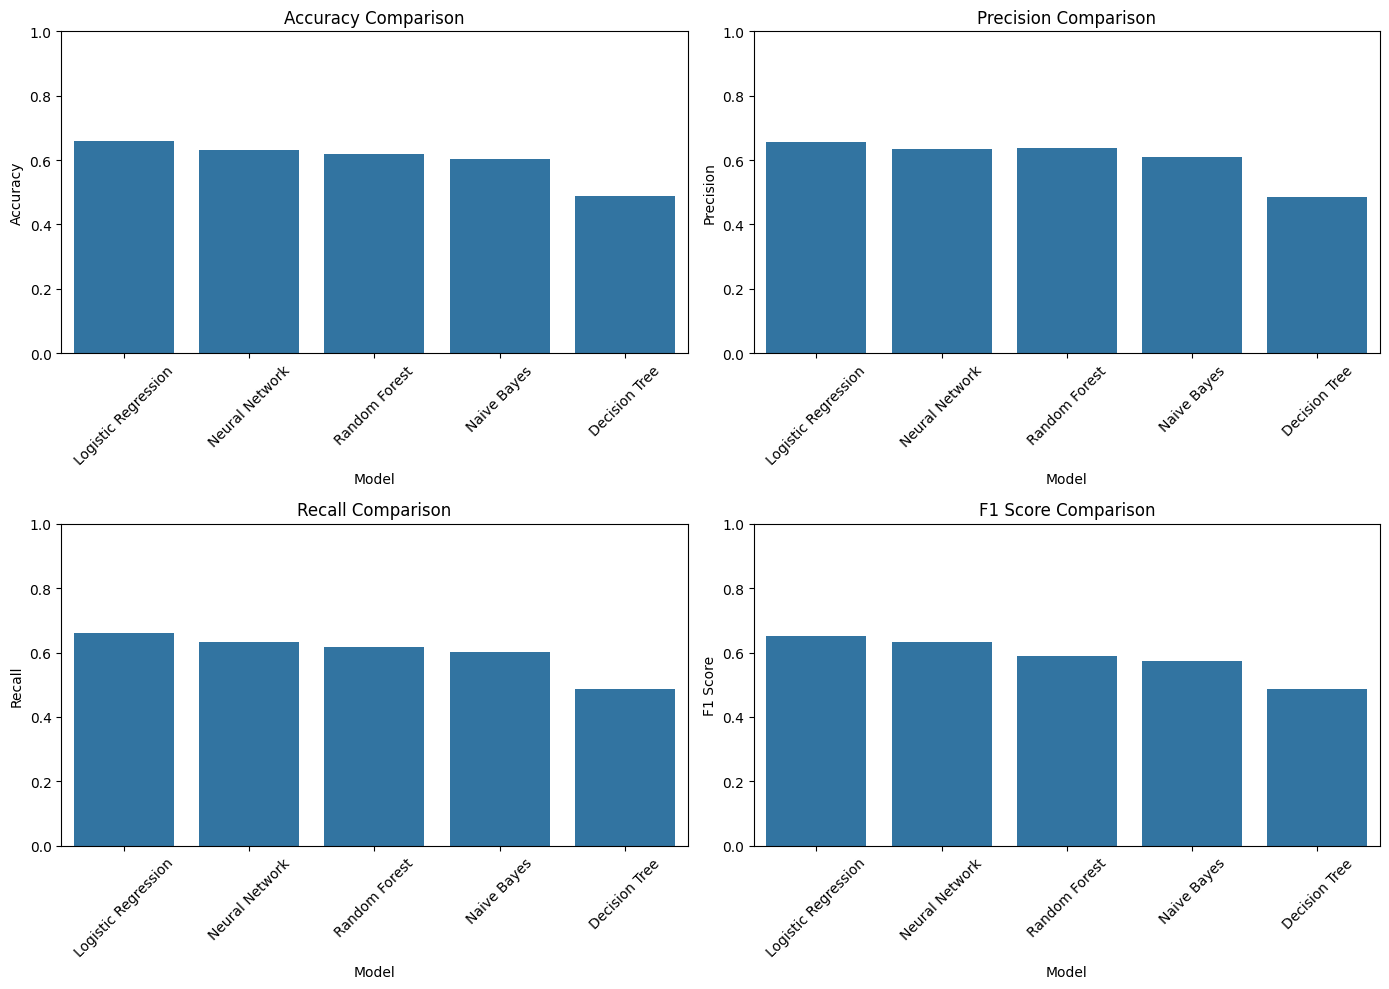


Detailed Classification Report for Logistic Regression:
                           precision    recall  f1-score   support

          AI and Robotics       0.56      0.31      0.40       224
         Banking Services       0.65      0.52      0.58       262
         Biotech Research       0.71      0.82      0.76       252
       Cloud and Software       0.65      0.74      0.69      1126
     Consumer Electronics       0.60      0.72      0.65       622
    Corporate Performance       0.57      0.71      0.63       894
            Cybersecurity       0.68      0.61      0.64       378
         Digital Services       0.58      0.54      0.56       387
 Emerging Energy Research       0.47      0.39      0.43        99
          Enterprise Tech       0.51      0.39      0.44       508
     Financial Technology       0.00      0.00      0.00        42
     Hardware and Devices       0.71      0.73      0.72       863
         Health Insurance       1.00      0.62      0.76        21
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


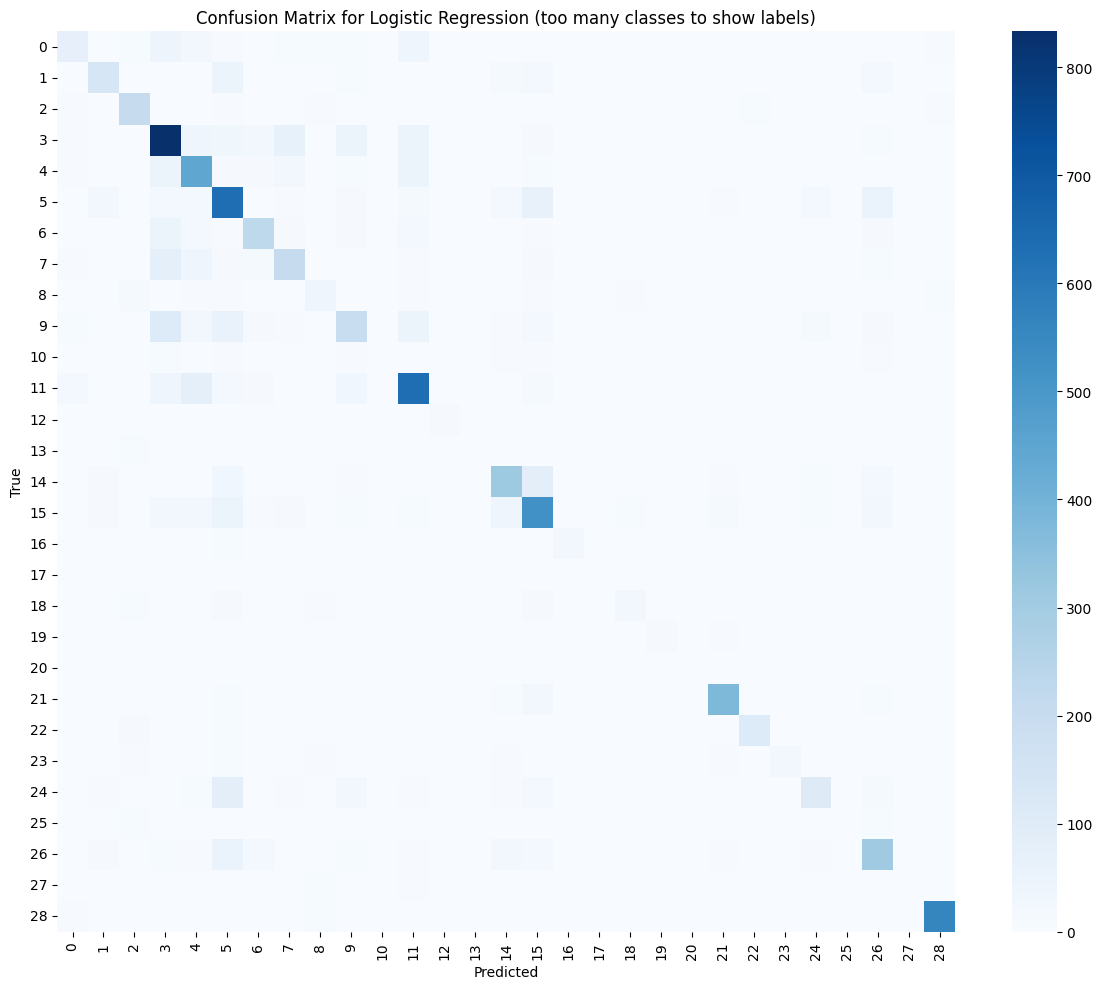

In [13]:
# Create a DataFrame for results comparison
results_df = pd.DataFrame(model_results)

# Sort by F1 Score
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display results
print("Model Performance Comparison:")
print(results_df)

# Plot metrics comparison
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Precision plot
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=results_df)
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Recall plot
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=results_df)
plt.title('Recall Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# F1 Score plot
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1 Score', data=results_df)
plt.title('F1 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Create a detailed classification report for the best model
best_model_name = results_df.iloc[0]['Model']
print(f"\nDetailed Classification Report for {best_model_name}:")

if best_model_name == 'Naive Bayes':
    y_pred = y_pred_nb
elif best_model_name == 'Decision Tree':
    y_pred = y_pred_dt
elif best_model_name == 'Random Forest':
    y_pred = y_pred_rf
elif best_model_name == 'Logistic Regression':
    y_pred = y_pred_lr
# elif best_model_name == 'SVM':
#     y_pred = y_pred_svm
# elif best_model_name == 'LDA':
#     y_pred = y_pred_lda
else:  # Neural Network
    y_pred = y_pred_nn

print(classification_report(y_test, y_pred))

# Create a confusion matrix for the best model
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
# If there are too many classes, show a heatmap without class labels
if len(np.unique(y_test)) > 15:
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(f'Confusion Matrix for {best_model_name} (too many classes to show labels)')
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

K-Fold Cross-Validation

In [ ]:
# Perform K-Fold cross-validation on all models
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create a list of all models for cross-validation
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Define scoring metrics
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Dictionary to store cross-validation results
cv_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Perform cross-validation for each model
for name, model in models.items():
    print(f"\nCross-validation for {name}:")

    # Skip LDA because it requires dense input
    if name == 'LDA':
        scores = cross_validate(model, X_tfidf.toarray(), y, cv=kf, scoring=scoring)
    else:
        scores = cross_validate(model, X_tfidf, y, cv=kf, scoring=scoring)

    # Calculate mean scores
    mean_accuracy = np.mean(scores['test_accuracy'])
    mean_precision = np.mean(scores['test_precision_weighted'])
    mean_recall = np.mean(scores['test_recall_weighted'])
    mean_f1 = np.mean(scores['test_f1_weighted'])

    # Print scores
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}")

    # Store results for comparison
    cv_results['Model'].append(name)
    cv_results['Accuracy'].append(mean_accuracy)
    cv_results['Precision'].append(mean_precision)
    cv_results['Recall'].append(mean_recall)
    cv_results['F1 Score'].append(mean_f1)

# Create DataFrame for CV results comparison
cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

# Display CV results
print("\nCross-Validation Results Comparison:")
print(cv_results_df)

# Plot CV results
plt.figure(figsize=(14, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=cv_results_df)
plt.title(f'{k}-Fold CV: Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Precision plot
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=cv_results_df)
plt.title(f'{k}-Fold CV: Precision Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Recall plot
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=cv_results_df)
plt.title(f'{k}-Fold CV: Recall Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# F1 Score plot
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1 Score', data=cv_results_df)
plt.title(f'{k}-Fold CV: F1 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


Cross-validation for Naive Bayes:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mean Accuracy: 0.5993
Mean Precision: 0.6027
Mean Recall: 0.5993
Mean F1 Score: 0.5709

Cross-validation for Decision Tree:
Mean Accuracy: 0.4762
Mean Precision: 0.4728
Mean Recall: 0.4762
Mean F1 Score: 0.4738

Cross-validation for Random Forest:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean Accuracy: 0.6174
Mean Precision: 0.6493
Mean Recall: 0.6174
Mean F1 Score: 0.5906

Cross-validation for Logistic Regression:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Mean Accuracy: 0.6584
Mean Precision: 0.6550
Mean Recall: 0.6584
Mean F1 Score: 0.6489

Cross-validation for SVM:


Bonus: Clustering Analysis

In [ ]:
# Step 1: Dimensionality reduction for visualization
# Using TruncatedSVD (similar to PCA but works with sparse matrices)
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# Further reduce dimensions for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_svd)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'subtopic': df['subtopic'].values,
    'topic': df['topic'].values
})

# Step 2: K-Means Clustering
# Determine the number of clusters (we'll use the number of unique subtopics)
n_clusters = df['subtopic'].nunique()
print(f"Number of unique subtopics: {n_clusters}")

# Train KMeans model on the SVD-reduced features
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_svd)

# Add cluster assignments to the DataFrame
tsne_df['cluster'] = clusters

# Step 3: Visualization
plt.figure(figsize=(14, 10))

# Plot by subtopic
plt.subplot(1, 2, 1)
unique_subtopics = df['subtopic'].unique()
# If there are too many subtopics, only color the top 10 by frequency
if len(unique_subtopics) > 10:
    top_subtopics = df['subtopic'].value_counts().nlargest(10).index.tolist()
    colors = {subtopic: i for i, subtopic in enumerate(top_subtopics)}
    # For non-top subtopics, assign a common color
    tsne_df['color'] = tsne_df['subtopic'].apply(lambda x: colors.get(x, -1))

    # Plot points
    for i, subtopic in enumerate(top_subtopics):
        subset = tsne_df[tsne_df['subtopic'] == subtopic]
        plt.scatter(subset['x'], subset['y'], alpha=0.6, label=subtopic)

    # Plot other subtopics in gray
    other_subset = tsne_df[~tsne_df['subtopic'].isin(top_subtopics)]
    plt.scatter(other_subset['x'], other_subset['y'], alpha=0.3, color='gray', label='Other subtopics')
else:
    # If there aren't too many subtopics, color them all
    for subtopic in unique_subtopics:
        subset = tsne_df[tsne_df['subtopic'] == subtopic]
        plt.scatter(subset['x'], subset['y'], alpha=0.6, label=subtopic)

plt.title('t-SNE Visualization by Subtopic')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot by topic
plt.subplot(1, 2, 2)
for topic in df['topic'].unique():
    subset = tsne_df[tsne_df['topic'] == topic]
    plt.scatter(subset['x'], subset['y'], alpha=0.6, label=topic)

plt.title('t-SNE Visualization by Topic')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Plot by cluster
plt.figure(figsize=(14, 7))
for cluster_id in range(n_clusters):
    if cluster_id < 10:  # Only show first 10 clusters to avoid cluttering
        subset = tsne_df[tsne_df['cluster'] == cluster_id]
        plt.scatter(subset['x'], subset['y'], alpha=0.6, label=f'Cluster {cluster_id}')
    else:
        # Combine remaining clusters
        subset = tsne_df[tsne_df['cluster'] >= 10]
        plt.scatter(subset['x'], subset['y'], alpha=0.3, color='gray', label='Other clusters')
        break

plt.title('t-SNE Visualization by K-Means Cluster')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analyze cluster quality
# For each cluster, find the most common subtopic and topic
cluster_analysis = {
    'cluster_id': [],
    'size': [],
    'dominant_subtopic': [],
    'subtopic_percentage': [],
    'dominant_topic': [],
    'topic_percentage': []
}

for cluster_id in range(n_clusters):
    cluster_df = tsne_df[tsne_df['cluster'] == cluster_id]

    # Get cluster size
    cluster_size = cluster_df.shape[0]

    # Find dominant subtopic
    subtopic_counts = cluster_df['subtopic'].value_counts()
    dominant_subtopic = subtopic_counts.index[0]
    subtopic_percentage = (subtopic_counts.iloc[0] / cluster_size) * 100

    # Find dominant topic
    topic_counts = cluster_df['topic'].value_counts()
    dominant_topic = topic_counts.index[0]
    topic_percentage = (topic_counts.iloc[0] / cluster_size) * 100

    # Store the results
    cluster_analysis['cluster_id'].append(cluster_id)
    cluster_analysis['size'].append(cluster_size)
    cluster_analysis['dominant_subtopic'].append(dominant_subtopic)
    cluster_analysis['subtopic_percentage'].append(subtopic_percentage)
    cluster_analysis['dominant_topic'].append(dominant_topic)
    cluster_analysis['topic_percentage'].append(topic_percentage)

# Create DataFrame with cluster analysis
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df = cluster_analysis_df.sort_values(by='size', ascending=False).reset_index(drop=True)

# Display cluster analysis
print("\nCluster Analysis - Top 10 clusters by size:")
print(cluster_analysis_df.head(10))

# Calculate overall clustering quality metrics
from sklearn.metrics import silhouette_score
print("\nClustering Quality Metrics:")
# Silhouette score requires dense input and can be computationally expensive for large datasets
# So we'll compute it on a sample if the dataset is large
if X_svd.shape[0] > 10000:
    sample_indices = np.random.choice(X_svd.shape[0], 10000, replace=False)
    silhouette_avg = silhouette_score(X_svd[sample_indices], clusters[sample_indices])
else:
    silhouette_avg = silhouette_score(X_svd, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

In [ ]:
# Calculate how well clusters align with actual subtopics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(df['subtopic'].values, clusters)
nmi = normalized_mutual_info_score(df['subtopic'].values, clusters)

print(f"Adjusted Rand Index (subtopics): {ari:.4f}")
print(f"Normalized Mutual Information (subtopics): {nmi:.4f}")

# Calculate clustering metrics for topics as well
topic_ari = adjusted_rand_score(df['topic'].values, clusters)
topic_nmi = normalized_mutual_info_score(df['topic'].values, clusters)

print(f"Adjusted Rand Index (topics): {topic_ari:.4f}")
print(f"Normalized Mutual Information (topics): {topic_nmi:.4f}")

# Identify the most representative words for each cluster
# Get the cluster centers
centers = kmeans.cluster_centers_

# For each cluster, get the top words
top_words_per_cluster = {}
for i in range(n_clusters):
    # Get the indices of the top terms
    top_indices = centers[i].argsort()[-10:][::-1]
    # Get the feature names
    top_terms = [feature_names[idx] for idx in top_indices]
    top_words_per_cluster[i] = top_terms

# Display top words for the largest clusters
print("\nTop words for the largest clusters:")
for i in range(min(5, len(cluster_analysis_df))):
    cluster_id = cluster_analysis_df.iloc[i]['cluster_id']
    print(f"Cluster {cluster_id} (Size: {cluster_analysis_df.iloc[i]['size']}):")
    print(f"Dominant Subtopic: {cluster_analysis_df.iloc[i]['dominant_subtopic']} "
          f"({cluster_analysis_df.iloc[i]['subtopic_percentage']:.1f}%)")
    print(f"Dominant Topic: {cluster_analysis_df.iloc[i]['dominant_topic']} "
          f"({cluster_analysis_df.iloc[i]['topic_percentage']:.1f}%)")
    print(f"Top Words: {', '.join(top_words_per_cluster[cluster_id])}")
    print()

Final Conclusions and Summary

In [ ]:
# # Get the best performing model based on CV results
# best_model_name = cv_results_df.iloc[0]['Model']
# best_f1_score = cv_results_df.iloc[0]['F1 Score']

# print(f"Best performing model: {best_model_name} with F1 Score of {best_f1_score:.4f}")

# # Get key insights from the clustering analysis
# # Calculate how well clusters align with actual subtopics
# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
# ari = adjusted_rand_score(df['subtopic'].values, clusters)
# nmi


# Create a summary of findings
print("================ NEWS ARTICLES CLASSIFICATION SUMMARY ================")
print(f"Dataset: {df.shape[0]} articles with {df['subtopic'].nunique()} subtopics and {df['topic'].nunique()} topics")
print("\n1. MODEL PERFORMANCE SUMMARY:")
print(f"   Best model (based on cross-validation): {best_model_name} with F1 Score of {best_f1_score:.4f}")
print("   Performance comparison of all models:")
print(cv_results_df[['Model', 'F1 Score']].to_string(index=False))

print("\n2. CLUSTERING ANALYSIS SUMMARY:")
print(f"   Number of clusters: {n_clusters} (same as number of subtopics)")
print(f"   Clustering alignment with subtopics (NMI): {nmi:.4f}")
print(f"   Clustering alignment with topics (NMI): {topic_nmi:.4f}")

# Calculate the percentage of clusters that are "pure" (>70% dominated by a single subtopic)
pure_clusters = cluster_analysis_df[cluster_analysis_df['subtopic_percentage'] > 70]
pure_percentage = (pure_clusters.shape[0] / n_clusters) * 100
print(f"   Percentage of 'pure' clusters (>70% single subtopic): {pure_percentage:.1f}%")

# Identify subtopics that cluster well vs poorly
# Get the dominant subtopic for each cluster
dominant_subtopics = cluster_analysis_df['dominant_subtopic'].tolist()
# Calculate how many unique subtopics are represented as dominant in clusters
unique_dominant = len(set(dominant_subtopics))
print(f"   Unique subtopics represented as dominant in clusters: {unique_dominant} out of {df['subtopic'].nunique()}")

print("\n3. KEY FINDINGS:")
print("   a. Text Classification:")
if best_f1_score > 0.8:
    print("      - High classification performance, suggesting strong distinctiveness between subtopics")
elif best_f1_score > 0.6:
    print("      - Moderate classification performance, suggesting some overlap between subtopics")
else:
    print("      - Lower classification performance, suggesting significant overlap or complexity in subtopics")

# Compare traditional ML vs Neural Network performance
traditional_models = ['Naive Bayes', 'Logistic Regression', 'SVM', 'LDA']
nn_score = cv_results_df[cv_results_df['Model'] == 'Neural Network']['F1 Score'].values[0]
traditional_scores = cv_results_df[cv_results_df['Model'].isin(traditional_models)]['F1 Score'].max()

if nn_score > traditional_scores:
    print("      - Neural network outperformed traditional models, suggesting complex patterns in the data")
else:
    print("      - Traditional models performed well, suggesting linear separability of classes")

print("   b. Clustering Analysis:")
if nmi > 0.7:
    print("      - Strong alignment between clusters and actual subtopics")
elif nmi > 0.4:
    print("      - Moderate alignment between clusters and actual subtopics")
else:
    print("      - Weaker alignment between clusters and actual subtopics")

if topic_nmi > nmi:
    print("      - Clusters align better with topics than subtopics, suggesting stronger topic-level patterns")
else:
    print("      - Subtopics have distinct patterns beyond their parent topics")

print("\n4. RECOMMENDATIONS:")
print("   a. For model selection:")
print(f"      - Based on this analysis, {best_model_name} is recommended for subtopic classification")
print("      - Consider ensemble methods combining the top performing models for potential improvement")

if best_f1_score < 0.7:
    print("      - Explore feature engineering techniques to improve classification performance")
    print("      - Consider hierarchical classification (topic first, then subtopic)")

print("   b. For feature extraction:")
print("      - TF-IDF vectorization worked well, but could experiment with word embeddings")
print("      - Consider n-grams to capture multi-word patterns")

print("   c. For further analysis:")
print("      - Explore misclassifications to identify confusing subtopic pairs")
print("      - Consider topic modeling approaches like LDA to discover latent themes")
print("      - Implement a deep learning approach (e.g., BERT, RoBERTa) for potentially better results")

print("\n=====================================================================")

In [ ]:
Bonus: Error Analysis

In [ ]:
# Get predictions from the best performing model
def get_best_model_predictions():
    if best_model_name == 'Naive Bayes':
        model = MultinomialNB()
    elif best_model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
    elif best_model_name == 'Random Forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif best_model_name == 'Logistic Regression':
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif best_model_name == 'SVM':
        model = SVC(kernel='linear', random_state=42)
    elif best_model_name == 'LDA':
        model = LinearDiscriminantAnalysis()
        model.fit(X_train.toarray(), y_train)
        return model.predict(X_test.toarray())
    else:  # Neural Network
        model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

    model.fit(X_train, y_train)
    return model.predict(X_test)

# Get the predictions
best_predictions = get_best_model_predictions()

# Create a DataFrame for error analysis
error_df = pd.DataFrame({
    'true_subtopic': y_test,
    'predicted_subtopic': best_predictions,
    'correct': y_test == best_predictions
})

# Add the original text
test_indices = np.arange(len(df))[len(y_train):]  # Assuming the order is preserved during train_test_split
error_df['title'] = df.iloc[test_indices]['title'].values
error_df['description'] = df.iloc[test_indices]['description'].values
error_df['topic'] = df.iloc[test_indices]['topic'].values

# Get the most frequently misclassified subtopics
misclassified = error_df[~error_df['correct']]
misclass_counts = misclassified['true_subtopic'].value_counts()
print("Top 10 most frequently misclassified subtopics:")
print(misclass_counts.head(10))

# Calculate misclassification rate by subtopic
subtopic_error_rates = {}
for subtopic in error_df['true_subtopic'].unique():
    subtopic_df = error_df[error_df['true_subtopic'] == subtopic]
    error_rate = 1 - subtopic_df['correct'].mean()
    subtopic_error_rates[subtopic] = error_rate

# Convert to DataFrame for analysis
subtopic_error_df = pd.DataFrame({
    'subtopic': list(subtopic_error_rates.keys()),
    'error_rate': list(subtopic_error_rates.values()),
    'count': error_df['true_subtopic'].value_counts().reindex(subtopic_error_rates.keys()).values
})
subtopic_error_df = subtopic_error_df.sort_values('error_rate', ascending=False).reset_index(drop=True)

# Display most problematic subtopics (high error rate and reasonable sample size)
print("\nMost problematic subtopics (error rate > 30% and at least 10 samples):")
problematic = subtopic_error_df[(subtopic_error_df['error_rate'] > 0.3) & (subtopic_error_df['count'] >= 10)]
print(problematic)

# Confusion pattern analysis: where do misclassifications go?
confusion_patterns = {}
for subtopic in problematic['subtopic']:
    # Get all instances of this subtopic
    subtopic_instances = misclassified[misclassified['true_subtopic'] == subtopic]
    # Count where they were misclassified to
    misclass_destinations = subtopic_instances['predicted_subtopic'].value_counts()
    confusion_patterns[subtopic] = misclass_destinations.head(3).to_dict()  # Top 3 destinations

# Display confusion patterns
print("\nTop misclassification patterns:")
for subtopic, destinations in confusion_patterns.items():
    print(f"\n{subtopic} is most often misclassified as:")
    for wrong_subtopic, count in destinations.items():
        print(f"  - {wrong_subtopic}: {count} instances")

# Error examples
print("\nExamples of misclassifications for most problematic subtopics:")
for subtopic in problematic['subtopic'].head(3):  # Top 3 problematic subtopics
    examples = misclassified[misclassified['true_subtopic'] == subtopic].head(2)  # 2 examples per subtopic
    for _, example in examples.iterrows():
        print(f"\nTitle: {example['title']}")
        print(f"True Subtopic: {example['true_subtopic']}")
        print(f"Predicted Subtopic: {example['predicted_subtopic']}")
        print(f"Topic: {example['topic']}")
        print(f"Description: {example['description'][:100]}...")  # Show only the beginning

Bonus: Interactive Visualization with Plotly

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create an interactive scatter plot of the t-SNE visualization
# If the dataset is large, use a sample for better visualization
sample_size = min(5000, len(tsne_df))
sample_indices = np.random.choice(len(tsne_df), sample_size, replace=False)
sample_df = tsne_df.iloc[sample_indices].copy()

# Create colorful visualization by topic
fig_topic = px.scatter(
    sample_df, x='x', y='y', color='topic',
    title='Interactive t-SNE Visualization by Topic',
    labels={'x': 't-SNE feature 1', 'y': 't-SNE feature 2'},
    hover_data=['subtopic']
)
fig_topic.update_traces(marker=dict(size=8, opacity=0.7))
fig_topic.update_layout(height=700, width=1000)
fig_topic.show()

# Create colorful visualization by cluster
fig_cluster = px.scatter(
    sample_df, x='x', y='y', color='cluster',
    title='Interactive t-SNE Visualization by Cluster',
    labels={'x': 't-SNE feature 1', 'y': 't-SNE feature 2'},
    hover_data=['subtopic', 'topic'],
    color_continuous_scale=px.colors.qualitative.G10
)
fig_cluster.update_traces(marker=dict(size=8, opacity=0.7))
fig_cluster.update_layout(height=700, width=1000)
fig_cluster.show()

# Create interactive comparison of model performance
fig_models = go.Figure()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = cv_results_df['Model'].tolist()

for metric in metrics:
    fig_models.add_trace(go.Bar(
        x=models,
        y=cv_results_df[metric],
        name=metric
    ))

fig_models.update_layout(
    title='Model Performance Comparison',
    xaxis_title='Model',
    yaxis_title='Score',
    barmode='group',
    height=600,
    width=1000
)
fig_models.show()

Further Improvement Suggestions

In [ ]:
# Potential improvements
improvement_suggestions = [
    {
        "area": "Feature Engineering",
        "suggestions": [
            "Experiment with word embeddings (Word2Vec, GloVe, FastText)",
            "Include n-grams (bigrams, trigrams) to capture multi-word expressions",
            "Apply feature selection techniques to reduce dimensionality",
            "Try topic modeling features (LDA, NMF) as additional inputs",
            "Include text metadata features (text length, readability scores, etc.)"
        ]
    },
    {
        "area": "Model Selection",
        "suggestions": [
            "Implement more sophisticated ensemble methods (Stacking, Voting)",
            "Fine-tune hyperparameters using Grid Search or Bayesian Optimization",
            "Try hierarchical classification (classify topic first, then subtopic)",
            "Implement state-of-the-art transformer models (BERT, RoBERTa, etc.)",
            "Use more complex neural architectures (CNN, LSTM, Attention mechanisms)"
        ]
    },
    {
        "area": "Data Processing",
        "suggestions": [
            "Apply more advanced text preprocessing (entity recognition, stemming)",
            "Handle class imbalance with techniques like SMOTE or class weights",
            "Augment training data for underrepresented classes",
            "Incorporate active learning for difficult-to-classify instances",
            "Implement data cleaning for potentially mislabeled instances"
        ]
    },
    {
        "area": "Evaluation",
        "suggestions": [
            "Use stratified sampling to ensure representative evaluation",
            "Implement time-based validation for news article data",
            "Add interpretability analysis to understand model decisions",
            "Perform error analysis on specific subtopic confusion patterns",
            "Evaluate model performance under various real-world constraints"
        ]
    }
]

# Display the improvement suggestions
for area in improvement_suggestions:
    print(f"\n{area['area']}:")
    for i, suggestion in enumerate(area['suggestions'], 1):
        print(f"  {i}. {suggestion}")